In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#ATTENTION il faudra lui faire un fichier avec tous les packages à importer

In [81]:
file_path = "C:/Users/Utilisateur/Documents/École/S1/python/ESS11/ESS11.csv"

dfess = pd.read_csv(file_path, sep=';', low_memory=False)


In [82]:
dfess.describe()
print(df.columns.tolist())

['name', 'essround', 'edition', 'proddate', 'idno', 'cntry', 'dweight', 'pspwght', 'pweight', 'anweight', 'nwspol', 'netusoft', 'netustm', 'ppltrst', 'pplfair', 'pplhlp', 'polintr', 'psppsgva', 'actrolga', 'psppipla', 'cptppola', 'trstprl', 'trstlgl', 'trstplc', 'trstplt', 'trstprt', 'trstep', 'trstun', 'vote', 'prtvtdat', 'prtvtebe', 'prtvtfbg', 'prtvtchr', 'prtvtccy', 'prtvtffi', 'prtvtffr', 'prtvgde1', 'prtvgde2', 'prtvtegr', 'prtvthhu', 'prtvteis', 'prtvteie', 'prtvteil', 'prtvteit', 'prtvtblv', 'prtvclt1', 'prtvclt2', 'prtvclt3', 'prtvtbme', 'prtvtinl', 'prtvtcno', 'prtvtfpl', 'prtvtept', 'prtvtbrs', 'prtvtesk', 'prtvtgsi', 'prtvtges', 'prtvtdse', 'prtvthch', 'prtvtdgb', 'contplt', 'donprty', 'badge', 'sgnptit', 'pbldmna', 'bctprd', 'pstplonl', 'volunfp', 'clsprty', 'prtcleat', 'prtclebe', 'prtclfbg', 'prtclbhr', 'prtclccy', 'prtclgfi', 'prtclgfr', 'prtclgde', 'prtclegr', 'prtclihu', 'prtcleis', 'prtclfie', 'prtclfil', 'prtclfit', 'prtclblv', 'prtclclt', 'prtclbme', 'prtclhnl', 'p

Consommation moyenne en semaine (grammes) :
cntry
ME    66.254672
SK    52.053913
LT    48.561565
PL    40.561831
BG    37.739983
RS    36.538283
LV    34.800000
GB    33.562850
IT    31.121490
HR    28.991021
IE    28.740632
BE    27.960093
AT    27.829418
HU    27.042918
CY    26.437198
IS    25.485714
GR    25.177457
NO    23.951411
SE    23.431450
FI    23.137496
SI    21.556438
PT    19.897816
DE    19.036004
CH    18.558437
ES    16.054956
FR    16.024484
NL    16.005874
IL    14.250980
Name: alcwkdy, dtype: float64

Consommation moyenne en week-end (grammes) :
cntry
ME    80.775385
LT    79.313836
SK    66.899675
IE    63.653196
PL    62.224290
LV    60.215018
IS    56.295969
BG    53.076667
FI    53.056088
GB    52.609514
NO    52.399476
RS    51.166467
AT    47.239278
BE    46.446124
HU    46.276414
SE    45.522047
HR    42.623450
IT    41.791209
GR    40.151258
CY    34.693976
NL    34.436630
DE    33.754410
CH    33.016791
ES    32.543375
SI    29.977824
FR    27.549371
PT  

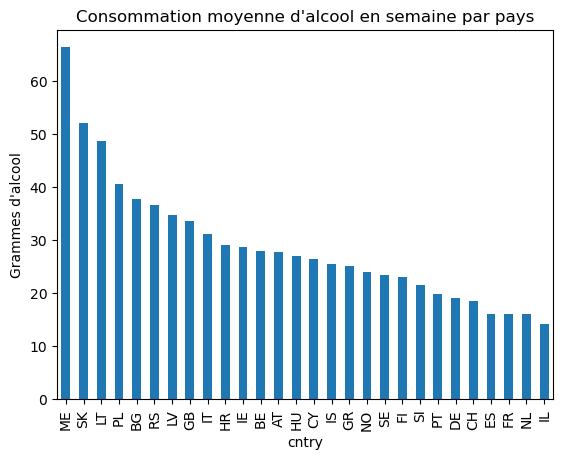

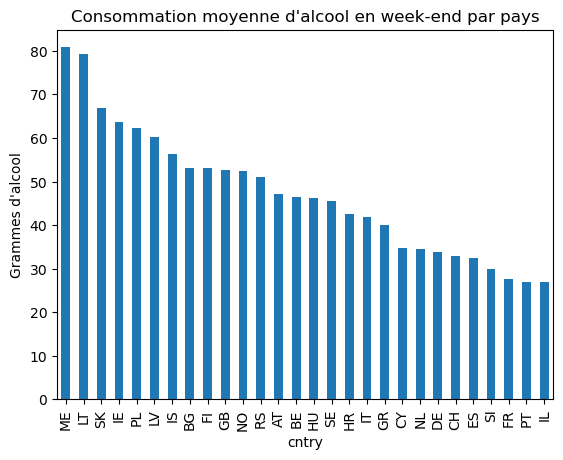

In [83]:
# sous data set: garde seulement les colonnes country + variables en lien avec l'alcool
alcohol_dataess = dfess[['cntry', 'alcfreq', 'alcwkdy', 'alcwknd','alcbnge']]

#ATTENTION PROVISOIRE
# Remplacer les codes de valeurs manquantes par NaN --SOLUTION PROVISOIRE IL FAUDRA VOIR SI LES NON REPONDANTS SONT REPARTIS relativement UNIFORMEMENT EN FONCTION DES AUTRES VARIABLES
alcohol_dataess.loc[:,'alcwkdy'] = alcohol_dataess['alcwkdy'].replace([6666, 7777, 8888, 9999], np.nan)
alcohol_dataess.loc[:,'alcwknd'] = alcohol_dataess['alcwknd'].replace([6666, 7777, 8888, 9999], np.nan)
alcohol_dataess.loc[:,'alcfreq'] = alcohol_dataess['alcfreq'].replace([77, 88, 99], np.nan)
alcohol_dataess.loc[:,'alcbnge'] = alcohol_dataess['alcbnge'].replace([6, 7,8,9], np.nan)

# Calculer la consommation moyenne par pays (en semaine et week-end)
mean_weekday = alcohol_dataess.groupby('cntry')['alcwkdy'].mean().sort_values(ascending=False)
mean_weekend = alcohol_dataess.groupby('cntry')['alcwknd'].mean().sort_values(ascending=False)


# Binge drinking par pays
binge_distribution = alcohol_dataess.groupby(['cntry', 'alcbnge']).size().unstack()


print("Consommation moyenne en semaine (grammes) :")
print(mean_weekday)
print("\nConsommation moyenne en week-end (grammes) :")
print(mean_weekend)

# Visualisation
mean_weekday.plot(kind='bar', title='Consommation moyenne d\'alcool en semaine par pays')
plt.ylabel('Grammes d\'alcool')
plt.show()

mean_weekend.plot(kind='bar', title='Consommation moyenne d\'alcool en week-end par pays')
plt.ylabel('Grammes d\'alcool')
plt.show()




In [84]:
# Fréquence de consommation par pays
freq_distribution = alcohol_dataess.groupby(['cntry', 'alcfreq']).size().unstack()

# Dictionnaire pour mapper les codes de fréquence aux libellés
freq_labels = {
    1: 'Every day',
    2: 'Several times a week',
    3: 'Once a week',
    4: '2-3 times a month',
    5: 'Once a month',
    6: 'Less than once a month',
    7: 'Never'
}
#nombre d'individus de chaque niveaux de consommation par pays
print("fréquence de consommation d'alcool par pays")
print(freq_labels)
print(freq_distribution)



# Calculer la distribution des fréquences par pays
freq_distribution = alcohol_dataess.groupby(['cntry', 'alcfreq']).size().unstack(fill_value=0)

# Renommer les colonnes avec les libellés
freq_distribution = freq_distribution.rename(columns=freq_labels)

# Calculer les proportions en pourcentage
freq_distribution_pct = freq_distribution.div(freq_distribution.sum(axis=1), axis=0) * 100

# Créer un DataFrame final avec les proportions en pourcentage
freq_table = freq_distribution_pct.round(2)

# Afficher le DataFrame
freq_table

fréquence de consommation d'alcool par pays
{1: 'Every day', 2: 'Several times a week', 3: 'Once a week', 4: '2-3 times a month', 5: 'Once a month', 6: 'Less than once a month', 7: 'Never'}
alcfreq  1.0  2.0  3.0  4.0  5.0  6.0   7.0
cntry                                      
AT       171  511  380  375  152  231   531
BE       141  360  304  186  113  192   297
BG       185  353  194  189   73  187  1043
CH        82  320  313  221  118  160   166
CY        27   62  104   75   57   99   257
DE       148  491  485  343  212  360   376
ES       187  247  324  148  135  230   572
FI        23  159  299  266  198  363   252
FR       142  310  370  185  145  211   402
GB       108  332  300  166  115  218   434
GR       118  325  575  446  196  397   689
HR       111  119  130  155  133  276   637
HU        51  128  144  178  108  323  1173
IE        58  276  442  197  161  241   635
IL        12   32   68   40   43   73   622
IS         7  103  128  167   93  166   177
IT       350  344 

alcfreq,Every day,Several times a week,Once a week,2-3 times a month,Once a month,Less than once a month,Never
cntry,,,,,,,
AT,7.27,21.74,16.16,15.95,6.47,9.83,22.59
BE,8.85,22.60,19.08,11.68,7.09,12.05,18.64
BG,8.32,15.87,8.72,8.50,3.28,8.41,46.90
CH,5.94,23.19,22.68,16.01,8.55,11.59,12.03
CY,3.96,9.10,15.27,11.01,8.37,14.54,37.74
DE,6.13,20.33,20.08,14.20,8.78,14.91,15.57
ES,10.15,13.40,17.58,8.03,7.33,12.48,31.04
FI,1.47,10.19,19.17,17.05,12.69,23.27,16.15
FR,8.05,17.56,20.96,10.48,8.22,11.95,22.78


In [85]:
def missing_values_proportion(df, country_col, variables):
    """
    Calcule le pourcentage de valeurs manquantes par pays pour chaque variable de alcohol_dataess.

    Args:
        df (DataFrame): Le DataFrame contenant les données
        country_col (str): Le nom de la colonne contenant les pays
        variables (list): Liste des noms des variables à analyser.

    Returns:
        DataFrame: Un DataFrame avec le pourcentage de valeurs manquantes par pays et par variable.
    """
    # Initialiser un dictionnaire pour stocker les résultats
    results = {}

    # Parcourir chaque variable
    for var in variables:
        # Calculer le nombre total de valeurs et le nombre de valeurs manquantes par pays
        total_counts = df.groupby(country_col).size()
        missing_counts = df.groupby(country_col)[var].apply(lambda x: x.isna().sum())

        # Calculer le pourcentage de valeurs manquantes
        missing_percent = (missing_counts / total_counts) * 100
        results[var] = missing_percent

    # Créer un DataFrame à partir des résultats
    missing_df = pd.DataFrame(results)

    return missing_df

In [86]:
variables =list([ 'alcfreq', 'alcwkdy', 'alcwknd','alcbnge'])
# Appeler la fonction
missing_proportions = missing_values_proportion(alcohol_dataess, 'cntry', variables)

# Afficher les résultats
print("Pourcentage de valeurs manquantes par pays et par variable :")
print(missing_proportions)

Pourcentage de valeurs manquantes par pays et par variable :
        alcfreq    alcwkdy    alcwknd    alcbnge
cntry                                           
AT     0.127443  23.322005  23.534410  22.939677
BE     0.062735  18.883312  19.071518  18.946048
BG     0.669942  47.431889  47.476552  47.699866
CH     0.289017  13.078035  13.078035  12.933526
CY     0.583942  39.562044  39.416058  38.102190
DE     0.206612  16.446281  16.611570  16.239669
ES     0.054230  31.616052  31.236443  31.236443
FI     0.191939  16.570697  16.506718  15.163148
FR     0.338792  23.433089  23.715415  23.320158
GB     0.653207  27.909739  29.156770  27.612827
GR     0.398984  25.825172  25.317374  25.172289
HR     0.127959  42.994242  43.250160   1.087652
HU     0.613787  55.996223  55.760151  55.571294
IE     0.347050  32.523550  32.523550  32.077343
IL     1.766004  71.854305  72.737307  69.867550
IS     0.118765  25.178147  23.396675  22.090261
IT     1.465969  42.827225  42.827225  44.712042
LT     0

On remarque que la part de valeur manquante n'est pas significative pour alcfreq, la fréquence de la consommation d'alcool. Par contre ça l'est pour les trois autres variables d'ESS11 portant sur l'alcool. On va donc comparer les deux base, pour le moment, que par rapport à alcfreq concernant la consommation d'alcool.

In [87]:
#La même chose sur la base deep seas



file_path2 = "C:/Users/Utilisateur/Documents/École/S1/python/Deepseas/20177113_DS_D3.1-SEAS2-dataset-2022_rev1.csv"

dfds = pd.read_csv(file_path2, sep=';', encoding='utf-8', low_memory=False)
dfds.describe()


,Respondent_Serial,SD_1,SD_2,QSD_2,SD_3,REG,REG_quota,WB_1,WB_2,WB_3,...,SD_21,COUNTRY,bsqf_1b,bsqf_3b,bsqf_5b,f_1b,consumers,SD_1_gender,social_class,SD_6Anumber
count,5.601400e+04,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,...,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000,56014.000000
mean,5.782639e+08,1.518781,41.056486,2.073624,16.854197,297.832167,1668.286946,2.121684,2.182204,1.958082,...,4.799782,25.607741,6.433374,6.802871,7.699093,5.156175,0.905631,1.517799,4.501803,2.730603
std,1.637197e+09,0.501969,12.820770,0.872051,10.191840,187.392295,997.947320,0.848583,0.934642,0.809487,...,3.663101,10.088834,2.935798,2.801623,2.595194,2.626167,0.292344,0.500651,3.197640,1.423003
min,1.900000e+01,1.000000,18.000000,1.000000,1.000000,1.000000,101.000000,1.000000,1.000000,1.000000,...,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,1.737850e+04,1.000000,30.000000,1.000000,8.000000,114.000000,801.000000,2.000000,2.000000,1.000000,...,1.000000,17.000000,4.000000,5.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000
50%,3.636400e+04,2.000000,41.000000,2.000000,16.000000,325.000000,1606.000000,2.000000,2.000000,2.000000,...,3.000000,25.000000,6.000000,7.000000,8.000000,5.000000,1.000000,2.000000,3.000000,3.000000
75%,5.647075e+04,2.000000,52.000000,3.000000,26.000000,411.000000,2502.000000,3.000000,3.000000,2.000000,...,9.000000,34.000000,9.000000,9.000000,10.000000,7.000000,1.000000,2.000000,9.000000,4.000000
max,7.600002e+09,3.000000,64.000000,3.000000,43.000000,1477.000000,3409.000000,6.000000,6.000000,6.000000,...,11.000000,43.000000,11.000000,11.000000,11.000000,11.000000,1.000000,3.000000,9.000000,20.000000


In [88]:
# Dictionnaire de mappage des numéros de pays vers les noms de pays
country_mapping = {
    10: 'Austria',
    11: 'Belgium',
    12: 'BosniaHerzegovina',
    13: 'Bulgaria',
    14: 'Catalunya',
    15: 'Croatia',
    16: 'Cyprus',
    17: 'Czech Republic',
    18: 'Denmark',
    19: 'Estonia',
    20: 'Finland',
    21: 'France',
    22: 'Germany',
    23: 'Greece',
    24: 'Hungary',
    25: 'Iceland',
    26: 'Ireland',
    27: 'Italy',
    28: 'Latvia',
    29: 'Lithuania',
    30: 'Luxembourg',
    31: 'Malta',
    32: 'Moldova',
    33: 'Netherlands',
    34: 'Norway',
    35: 'Poland',
    36: 'Portugal',
    37: 'Romania',
    38: 'Serbia',
    39: 'Slovakia',
    40: 'Slovenia',
    41: 'Spain',
    42: 'Sweden',
    43: 'United Kingdom',
}


#on change la base de données pour avoir les noms des pays
dfds['COUNTRY']= dfds['COUNTRY'].map(country_mapping)

In [89]:
# Sélection des colonnes pertinentes
alcohol_datads = dfds[['COUNTRY', 'cbsqf_alc', 'c1cbsqf_alc', 'RSOD_2b', 'RSOD_7b', 'rf_1b']]

"""il ne semblait pas y avoir de possibilité de "I prefer not to answer" pour aucune de ces variables qui n'ont donc pas besoin d'être recodées pour le moment"""


# Vérifier les valeurs manquantes dans les colonnes numériques
print(alcohol_datads[['cbsqf_alc', 'c1cbsqf_alc', 'RSOD_2b', 'RSOD_7b', 'rf_1b']].isnull().sum())
# Vérifier les types de données
print(alcohol_datads.dtypes)



cbsqf_alc      0
c1cbsqf_alc    0
RSOD_2b        0
RSOD_7b        0
rf_1b          0
dtype: int64
COUNTRY        object
cbsqf_alc      object
c1cbsqf_alc    object
RSOD_2b        object
RSOD_7b        object
rf_1b          object
dtype: object



Fréquence générale de consommation par pays (nombre de jours par an) :
COUNTRY
Bulgaria             176.035115
Italy                167.032468
Spain                158.205803
Portugal             148.427755
Romania              133.836262
Greece               131.064254
Catalunya             127.16248
Czech Republic       125.909798
United Kingdom        122.50417
Belgium               121.18125
France               120.329001
Croatia              119.527316
Netherlands          118.118491
Poland               114.224345
Ireland              112.508397
Slovakia             108.136929
Serbia               107.046531
Hungary              102.400643
Luxembourg           101.492158
Denmark               99.722443
Germany               98.272799
Austria                91.46256
Slovenia               88.40493
Latvia                83.348237
Malta                 82.127451
Lithuania             81.340641
Finland               79.304868
Sweden                 75.23301
BosniaHerzegovina     73

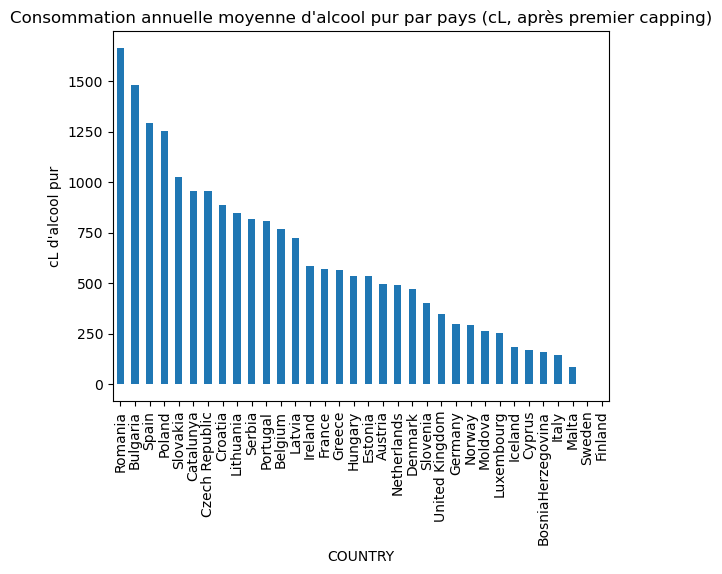

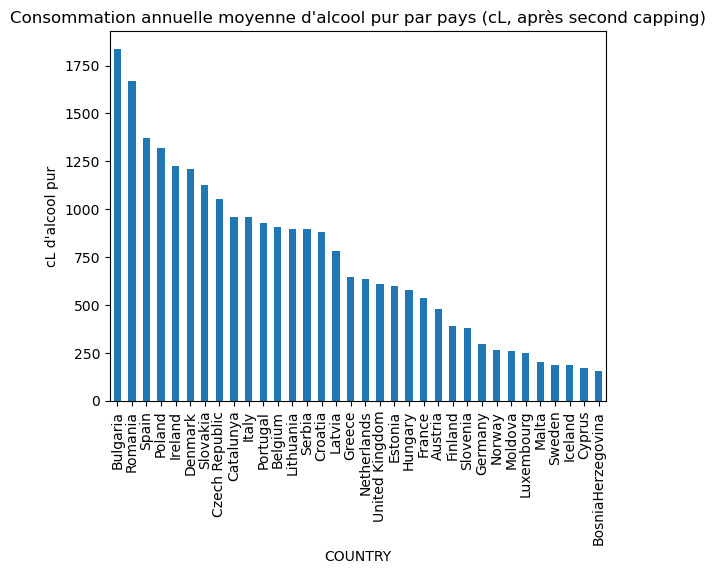

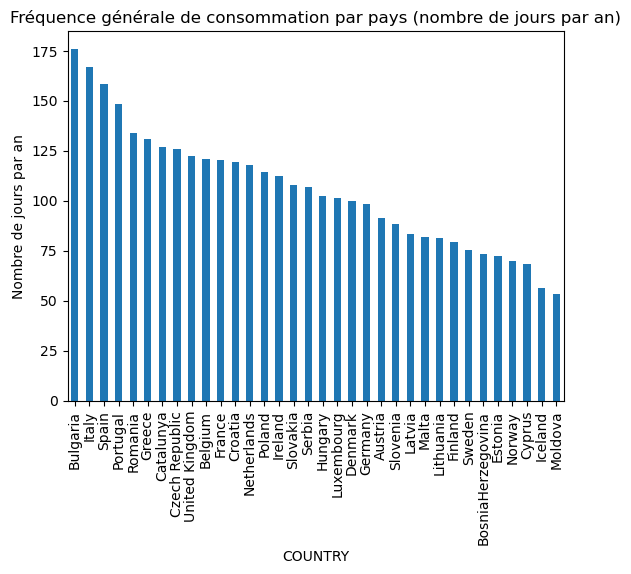

In [90]:

# On doit convertir toutes les colonnes de type object en numeric
cols_to_convert = ['cbsqf_alc', 'c1cbsqf_alc', 'RSOD_2b', 'RSOD_7b', 'rf_1b']


for col in cols_to_convert:
    alcohol_datads.loc[:, col] = pd.to_numeric(alcohol_datads[col], errors='coerce')
# Consommation annuelle moyenne d'alcool pur par pays (en cL)
mean_annual_capped = alcohol_datads.groupby('COUNTRY')['cbsqf_alc'].mean().sort_values(ascending=False)
mean_annual_double_capped = alcohol_datads.groupby('COUNTRY')['c1cbsqf_alc'].mean().sort_values(ascending=False)

# Fréquence de consommation excessive par pays (4/6+ verres et 8/12+ verres)
freq_4_6 = alcohol_datads.groupby('COUNTRY')['RSOD_2b'].value_counts(normalize=True).unstack()
freq_8_12 = alcohol_datads.groupby('COUNTRY')['RSOD_7b'].value_counts(normalize=True).unstack()

# Fréquence générale de consommation par pays (en nombre de jours par an)
freq_generic = alcohol_datads.groupby('COUNTRY')['rf_1b'].mean().sort_values(ascending=False)

# Affichage des résultats
"""print("Consommation annuelle moyenne d'alcool pur par pays (cL, après premier capping) :")
print(mean_annual_capped)
print("\nConsommation annuelle moyenne d'alcool pur par pays (cL, après second capping (cap:18.25L)) :")
print(mean_annual_double_capped)
print("\nFréquence de consommation de 4/6+ verres par pays (proportion) :")
print(freq_4_6)
print("\nFréquence de consommation de 8/12+ verres par pays (proportion) :")
print(freq_8_12)"""
print("\nFréquence générale de consommation par pays (nombre de jours par an) :")
print(freq_generic)

# Visualisation
mean_annual_capped.plot(kind='bar', title='Consommation annuelle moyenne d\'alcool pur par pays (cL, après premier capping)')
plt.ylabel('cL d\'alcool pur')
plt.show()

mean_annual_double_capped.plot(kind='bar', title='Consommation annuelle moyenne d\'alcool pur par pays (cL, après second capping)')
plt.ylabel('cL d\'alcool pur')
plt.show()

freq_generic.plot(kind='bar', title='Fréquence générale de consommation par pays (nombre de jours par an)')
plt.ylabel('Nombre de jours par an')
plt.show()

In [ ]:
#pour pouvoir comparer les fréquences de consommation d'alcool dans les deux bases on recode la variable rf_1b 
# qui décrit le nombre de jour où un individu a consommer de l'alcool sur l'année écoulée
# en une variable catégorielle comme "alcfreq" dans ESS11, allant de every day à never.


#EXPLIQUER CHOIX CATEGORIES + REVOIR CODE CI-DESSOUS

In [95]:
def transform_rf1b_to_category(rf1b_series):
    """
    Transforme la variable rf_1b en catégories selon les intervalles définis.

    Args:
        rf1b_series (Series): Série pandas contenant les valeurs de rf_1b.

    Returns:
        Series: Série pandas avec les catégories.
    """
    conditions = [
        (rf1b_series == 0),
        (rf1b_series >= 1) & (rf1b_series <= 11),
        (rf1b_series >= 12) & (rf1b_series <= 23),
        (rf1b_series >= 24) & (rf1b_series <= 36),
        (rf1b_series >= 37) & (rf1b_series <= 52),
        (rf1b_series >= 53) & (rf1b_series <= 250),
        (rf1b_series >= 251) & (rf1b_series <= 365)
    ]

    categories = [
        7,  # Never
        6,  # Less than once a month
        5,  # Once a month
        4,  # 2-3 times a month
        3,  # Once a week
        2,  # Several times a week
        1   # Every day
    ]

    return np.select(conditions, categories, default=np.nan)


alcohol_datads.loc[:,'rf1b_category'] = transform_rf1b_to_category(alcohol_datads['rf_1b'])



# Remplacer les codes numériques par les libellés
alcohol_datads.loc[:,'freq_labels'] = alcohol_datads['rf1b_category'].map(freq_labels)

# Afficher les premières lignes pour vérifier
print(alcohol_datads[['rf_1b', 'rf1b_category', 'freq_labels']].head())

   rf_1b  rf1b_category        freq_labels
0   12.0            5.0       Once a month
1  286.0            1.0          Every day
2    0.0            7.0              Never
3  286.0            1.0          Every day
4   30.0            4.0  2-3 times a month
